In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
import sklearn.model_selection

In [3]:
c0=sns.color_palette()[0]
c1=sns.color_palette()[1]
c2=sns.color_palette()[2]

cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

In [4]:
def points_plot(ax, Xtr, Xte, ytr, yte, clf, mesh=True, colorscale=cmap_light, 
                cdiscrete=cmap_bold, alpha=0.1, psize=10, zfunc=False, predicted=False):
    h = .02
    X=np.concatenate((Xtr, Xte))
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))

    #plt.figure(figsize=(10,6))
    if zfunc:
        p0 = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 0]
        p1 = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
        Z=zfunc(p0, p1)
    else:
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    ZZ = Z.reshape(xx.shape)
    if mesh:
        plt.pcolormesh(xx, yy, ZZ, cmap=cmap_light, alpha=alpha, axes=ax)
    if predicted:
        showtr = clf.predict(Xtr)
        showte = clf.predict(Xte)
    else:
        showtr = ytr
        showte = yte
    ax.scatter(Xtr[:, 0], Xtr[:, 1], c=showtr-1, cmap=cmap_bold, 
               s=psize, alpha=alpha,edgecolor="k")
    # and testing points
    ax.scatter(Xte[:, 0], Xte[:, 1], c=showte-1, cmap=cmap_bold, 
               alpha=alpha, marker="s", s=psize+10)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    return ax,xx,yy



In [5]:
def points_plot_prob(ax, Xtr, Xte, ytr, yte, clf, colorscale=cmap_light, 
                     cdiscrete=cmap_bold, ccolor=cm, psize=10, alpha=0.1):
    ax,xx,yy = points_plot(ax, Xtr, Xte, ytr, yte, clf, mesh=False, 
                           colorscale=colorscale, cdiscrete=cdiscrete, 
                           psize=psize, alpha=alpha, predicted=True) 
    Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=ccolor, alpha=.2, axes=ax)
    cs2 = plt.contour(xx, yy, Z, cmap=ccolor, alpha=.6, axes=ax)
    plt.clabel(cs2, fmt = '%2.1f', colors = 'k', fontsize=14, axes=ax)
    return ax 

In [2]:
dflog = pd.read_csv("data/01_heights_weights_genders.csv")
dflog.head()

,Gender,Height,Weight
0,Male,73.847017,241.893563
1,Male,68.781904,162.310473
2,Male,74.110105,212.740856
3,Male,71.730978,220.042470
4,Male,69.881796,206.349801


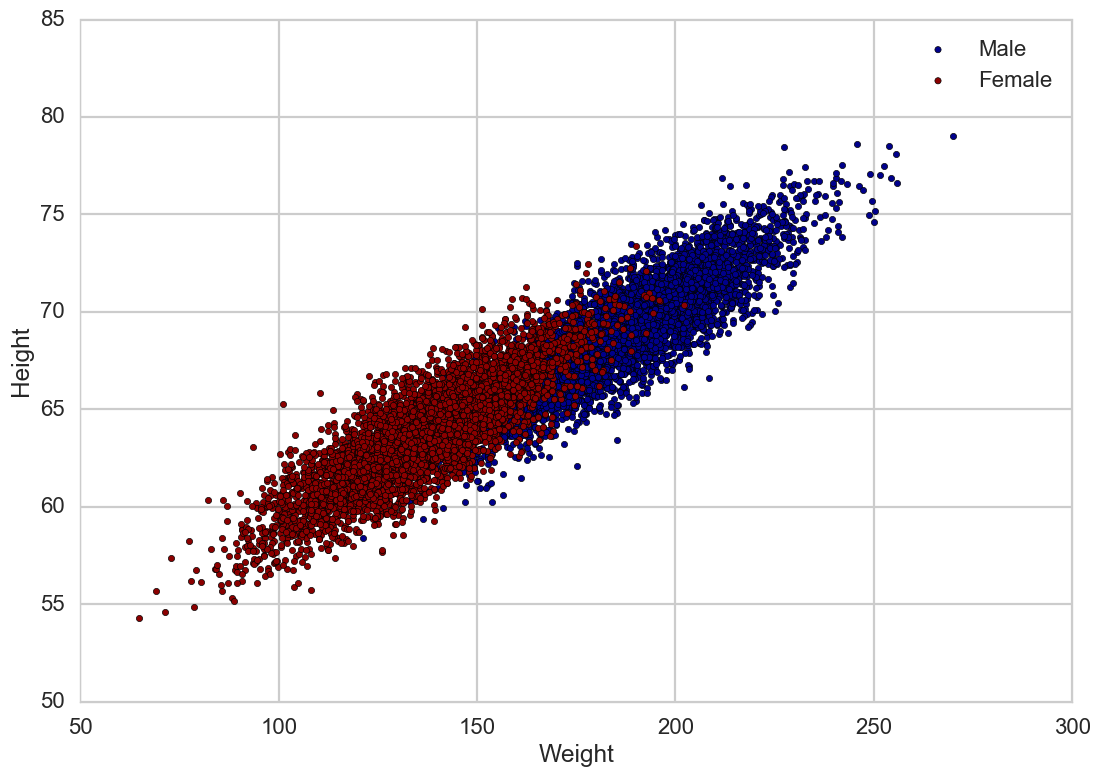

In [6]:
# plot scatter of weight vs. height
# color the points by Gender
ax = dflog[dflog.Gender == "Male"].plot.scatter(x='Weight', y='Height', color='DarkBlue', label='Male');
dflog[dflog.Gender == "Female"].plot.scatter(x='Weight', y='Height', color='DarkRed', label='Female', ax=ax);

In [9]:
#from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import StratifiedKFold, cross_val_score, train_test_split, KFold 

# Split the data into a training and test set.
Xlr, Xtestlr, ylr, ytestlr = train_test_split(dflog[['Height','Weight']].values, 
                                              (dflog.Gender == "Male").values,random_state=123)


/Users/tancy/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [12]:
clf = LogisticRegression()
kf = KFold(Xlr.shape[0], n_folds=10, random_state=123)
cv_results = cross_val_score(clf, 
                             Xlr, 
                             ylr, 
                             cv=kf, 
                             scoring='accuracy') 

msg = "%f (%f)" % (cv_results.mean(), cv_results.std())
print msg

0.919333 (0.010452)


In [14]:
clf.fit(Xlr,ylr)
print(accuracy_score(clf.predict(Xtestlr), ytestlr))

0.9184


In [15]:
#the grid of parameters to search over
Cs = [0.001, 0.1, 1, 10, 100]

for c in Cs:
    clf = LogisticRegression(C=c)
    clf.fit(Xlr,ylr)
    score = accuracy_score(clf.predict(Xlr),ylr)
    print "C and score: ", c, score

C and score:  0.001 0.919733333333
C and score:  0.1 0.92
C and score:  1 0.92
C and score:  10 0.92
C and score:  100 0.92


In [16]:
clf = LogisticRegression(C=100)
clf.fit(Xlr, ylr)
accuracy = accuracy_score(clf.predict(Xtestlr), ytestlr)
print(accuracy)

0.9184


In [18]:
from sklearn import grid_search
clf = grid_search.GridSearchCV(LogisticRegression(C=1), param_grid = {'C':[0.001, 0.1, 1, 10, 100]})
clf.fit(Xlr, ylr)
print "best parameter:", clf.best_params_
print "score:", clf.best_score_
print clf.grid_scores_

best parameter: {'C': 0.1}
score: 0.919733333333
[mean: 0.91907, std: 0.00167, params: {'C': 0.001}, mean: 0.91973, std: 0.00267, params: {'C': 0.1}, mean: 0.91960, std: 0.00270, params: {'C': 1}, mean: 0.91960, std: 0.00270, params: {'C': 10}, mean: 0.91960, std: 0.00270, params: {'C': 100}]


In [19]:
accuracy = accuracy_score(clf.predict(Xtestlr), ytestlr)
print("Accuracy: %f" % accuracy)

Accuracy: 0.918400


In [20]:
def cv_optimize(clf, parameters, Xtrain, ytrain, n_folds=5):
    gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds)
    gs.fit(Xtrain, ytrain)
    print "BEST PARAMS", gs.best_params_
    best = gs.best_estimator_
    return best

In [21]:
from sklearn.cross_validation import train_test_split
def do_classify(clf, parameters, indf, featurenames, targetname, target1val, standardize=False, train_size=0.8):
    subdf=indf[featurenames]
    if standardize:
        subdfstd=(subdf - subdf.mean())/subdf.std()
    else:
        subdfstd=subdf
    X=subdfstd.values
    y=(indf[targetname].values==target1val)*1
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size=train_size)
    clf = cv_optimize(clf, parameters, Xtrain, ytrain)
    clf=clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    print "Accuracy on training data: %0.2f" % (training_accuracy)
    print "Accuracy on test data:     %0.2f" % (test_accuracy)
    return clf, Xtrain, ytrain, Xtest, ytest

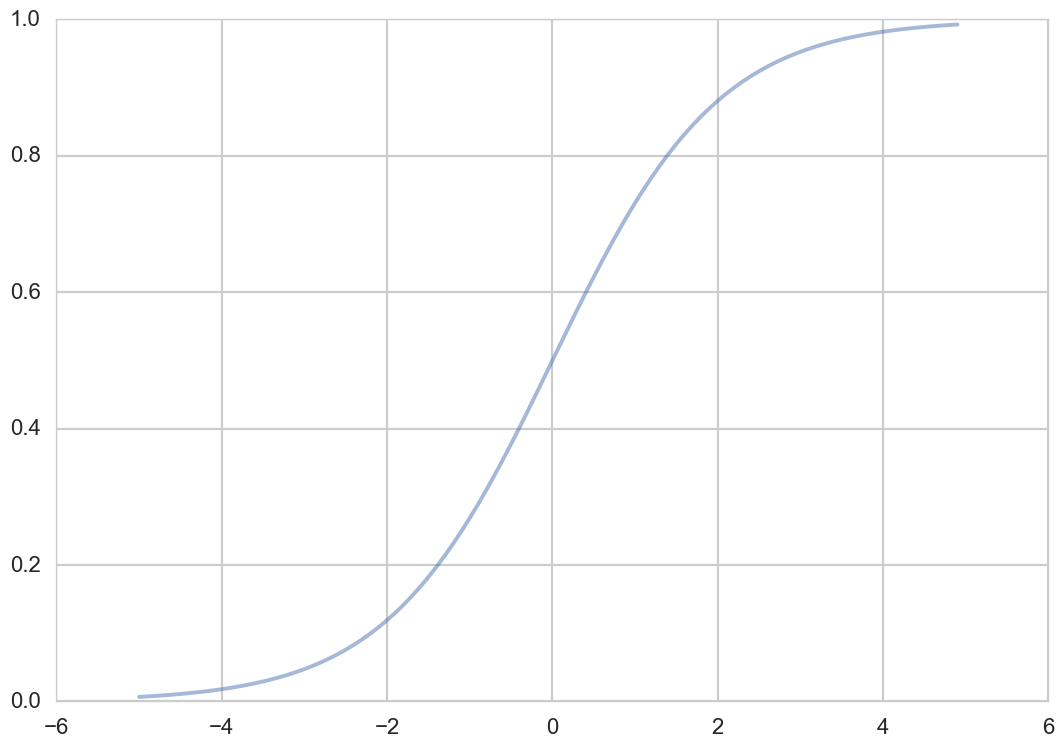

In [22]:
h = lambda z: 1./(1+np.exp(-z))
zs=np.arange(-5,5,0.1)
plt.plot(zs, h(zs), alpha=0.5);

In [24]:
from sklearn import grid_search
from sklearn.grid_search import GridSearchCV
clf_log, Xtrain_log, ytrain_log, Xtest_log, ytest_log  = do_classify(LogisticRegression(), 
                                                           {"C": [0.01, 0.1, 1, 10, 100]}, 
                                                           dflog, ['Weight', 'Height'], 'Gender','Male')

BEST PARAMS {'C': 0.01}
Accuracy on training data: 0.92
Accuracy on test data:     0.92


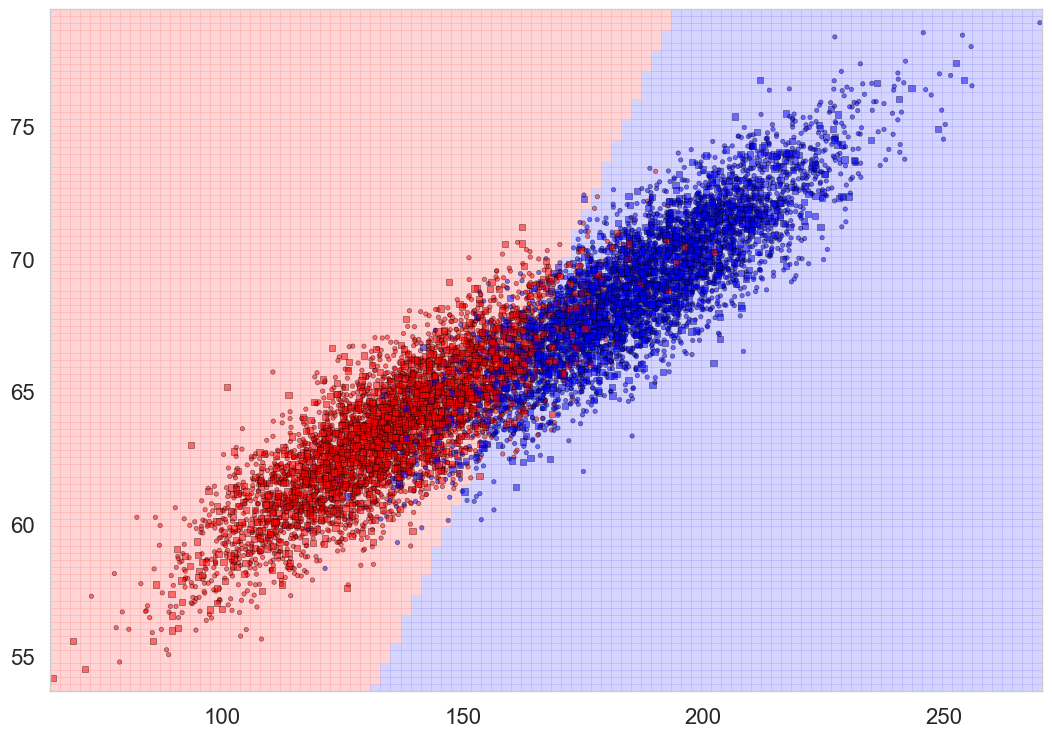

In [26]:
plt.figure()
ax=plt.gca()
points_plot(ax, Xtrain_log, Xtest_log, ytrain_log, ytest_log, clf_log, alpha=0.5);

In [27]:
clf_log.predict_proba(Xtest_log)

array([[ 0.99726688,  0.00273312],
       [ 0.03956524,  0.96043476],
       [ 0.63948506,  0.36051494],
       ..., 
       [ 0.00448457,  0.99551543],
       [ 0.29835338,  0.70164662],
       [ 0.00458108,  0.99541892]])

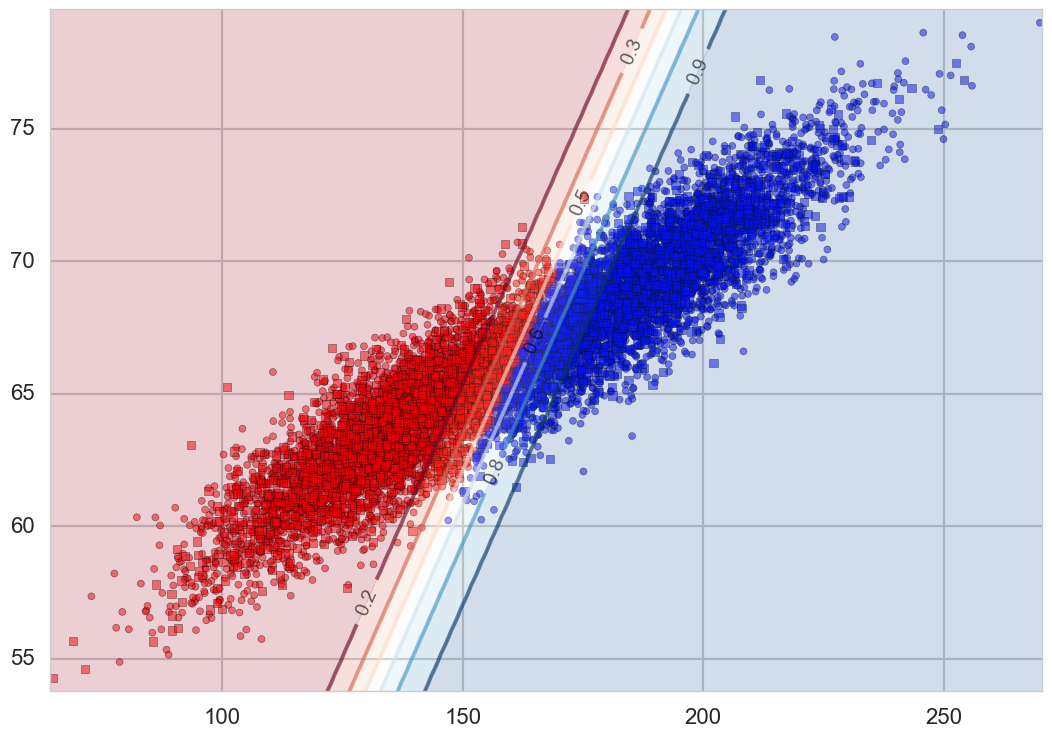

In [30]:
plt.figure()
ax=plt.gca()
points_plot_prob(ax, Xtrain_log, Xtest_log, ytrain_log, ytest_log, clf_log, psize=25, alpha=0.5);